# Regression Testing
This notebook tests the package for regression problems. We will use the Boston housing dataset from scikit-learn.

In [1]:
import pandas as pd
import numpy as np
import sys, os 

current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)

import mintpy
from sklearn.datasets import load_boston

In [2]:
# load in the dataset
data = load_boston()
examples = data['data']
targets = data['target']
feature_names = data['feature_names']


In [3]:
# make above into dataframe
examples = pd.DataFrame(data=examples, columns=feature_names)
print(examples.head(10))
print(examples.shape)
print(targets)

      CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575   65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421   78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185   61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998   45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147   54.2  6.0622  3.0  222.0   
5  0.02985   0.0   2.18   0.0  0.458  6.430   58.7  6.0622  3.0  222.0   
6  0.08829  12.5   7.87   0.0  0.524  6.012   66.6  5.5605  5.0  311.0   
7  0.14455  12.5   7.87   0.0  0.524  6.172   96.1  5.9505  5.0  311.0   
8  0.21124  12.5   7.87   0.0  0.524  5.631  100.0  6.0821  5.0  311.0   
9  0.17004  12.5   7.87   0.0  0.524  6.004   85.9  6.5921  5.0  311.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33  
5     18.7  394.1

In [4]:
# import a few regression type models
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# make instance for each model
enet_model = ElasticNet(random_state=42)
rf_model = RandomForestRegressor(n_estimators=25, random_state=42)
svr_model = SVR() 

# train 
enet_model.fit(examples, targets)
rf_model.fit(examples, targets)
svr_model.fit(examples, targets)

print(enet_model)
print(rf_model)
print(svr_model)

ElasticNet(random_state=42)
RandomForestRegressor(n_estimators=25, random_state=42)
SVR()


In [8]:
model_objs = [enet_model, rf_model, svr_model]
model_names = ['ElasticNet', 'RandomForest', 'SVR']

# make mintpy instance
interpreter = mintpy.InterpretToolkit(model=model_objs,
                                 model_names=model_names,
                                 examples=examples,
                                 targets=targets,
                                )

print(interpreter)

InterpretToolkit(model=OrderedDict([('ElasticNet', ElasticNet(random_state=42)), ('RandomForest', RandomForestRegressor(n_estimators=25, random_state=42)), ('SVR', SVR())]) 
                                  model_names=['ElasticNet', 'RandomForest', 'SVR'] 
                                  examples=<class 'pandas.core.frame.DataFrame'> length:506 
                                  targets=<class 'numpy.ndarray'> length:506 
                                  model_output=raw 
                                  feature_names=<class 'list'> length 13)


In [9]:
def run_regression_test(mintpy_instance):
    ''' Function to test the stability of a mint_py instance '''

    # calcultate permutation importance
    print("PI test...")
    pi_results = mintpy_instance.calc_permutation_importance(
                                               n_vars=10, 
                                               evaluation_fn='mse', 
                                               nbootstrap=50, 
                                               subsample=1.0,
                                               njobs=3
                                              )    
    
    # Save the permutation importance results as a pickle file
    mintpy_instance.save_results(fname='test_pi_regression.pkl',
                          data=pi_results) 

    # plot the permutation importance results
    print("Plotting PI...")
    fig = mintpy_instance.plot_importance(multipass=True, metric = "Training MSE")

    # Load the permutation importance results from the pickle file
    results = mintpy_instance.load_results(fnames='test_pi_regression.pkl',
                            option='permutation_importance',
                            model_names=mintpy_instance.model_names
                            )

    # get the top 6 most important features
    important_vars = mintpy_instance.get_important_vars(results, multipass=True, nvars=6)
    print(important_vars)

    # calculate ICE
    print("ICE test...")
    ice_results = mintpy_instance.calc_ice(features=important_vars, 
                                 nbootstrap=1, 
                                 subsample=0.25, 
                                 njobs=3, 
                                 nbins=20
                                )

    # calculate partial dependence
    print("PD test...")
    mintpy_instance.calc_pd(features=important_vars, 
                                 nbootstrap=1, 
                                 subsample=1.0, 
                                 njobs=3, 
                                 nbins=20
                                )
    # plotting PD
    print("Plotting PD...")
    fig, axes = mintpy_instance.plot_pd()

    # calculate ALE
    print("ALE test...")
    mintpy_instance.calc_ale(features=important_vars, 
                                 nbootstrap=1, 
                                 subsample=1.0, 
                                 njobs=3, 
                                 nbins=20
                                )

    # plotting ALE
    print("Plotting ALE...")
    fig, axes = mintpy_instance.plot_ale()


    # # plotting shap summary
    # mintpy_instance.plot_shap(features=None,
    #                     plot_type='summary', 
    #                     data_for_shap=examples, 
    #                     subsample_size=100,
    #                     performance_based=False)

    # # plot shap dependence plot
    # mintpy_instance.plot_shap(features=important_vars,
    #                     plot_type='dependence', 
    #                     data_for_shap=examples, 
    #                     subsample_size=100,
    #                     performance_based=False)

PI test...
Processing ElasticNet...
Using 3 of processors to compute importance...
Starting on the important variable 1 out of 10...
Starting on the important variable 2 out of 10...
Starting on the important variable 3 out of 10...
Starting on the important variable 4 out of 10...
Starting on the important variable 5 out of 10...
Starting on the important variable 6 out of 10...
Starting on the important variable 7 out of 10...
Starting on the important variable 8 out of 10...
Starting on the important variable 9 out of 10...
Starting on the important variable 10 out of 10...
Processing RandomForest...
Using 3 of processors to compute importance...
Starting on the important variable 1 out of 10...
Starting on the important variable 2 out of 10...
Starting on the important variable 3 out of 10...
Starting on the important variable 4 out of 10...
Starting on the important variable 5 out of 10...
Starting on the important variable 6 out of 10...
Starting on the important variable 7 out o

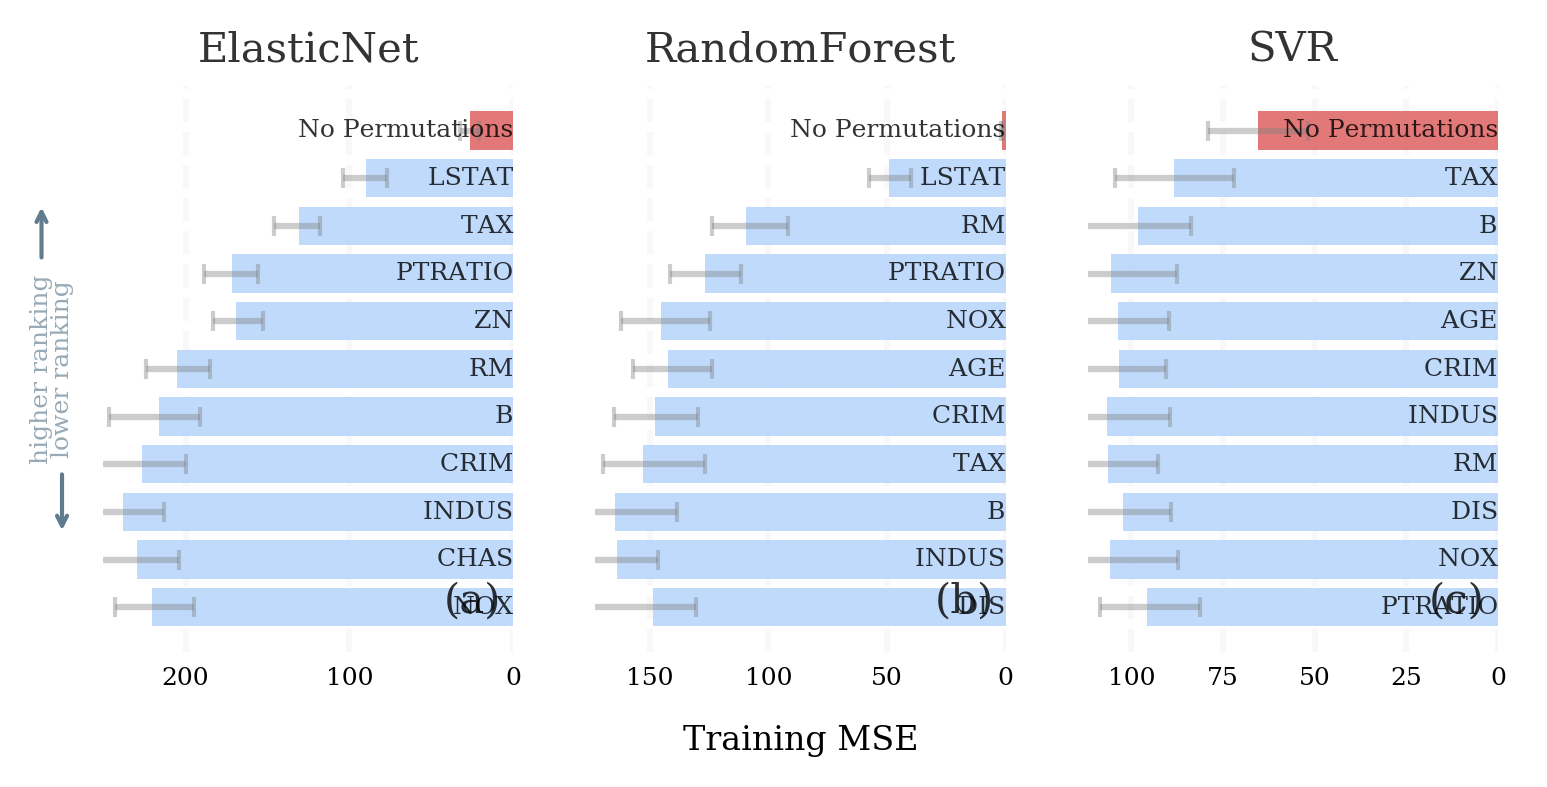

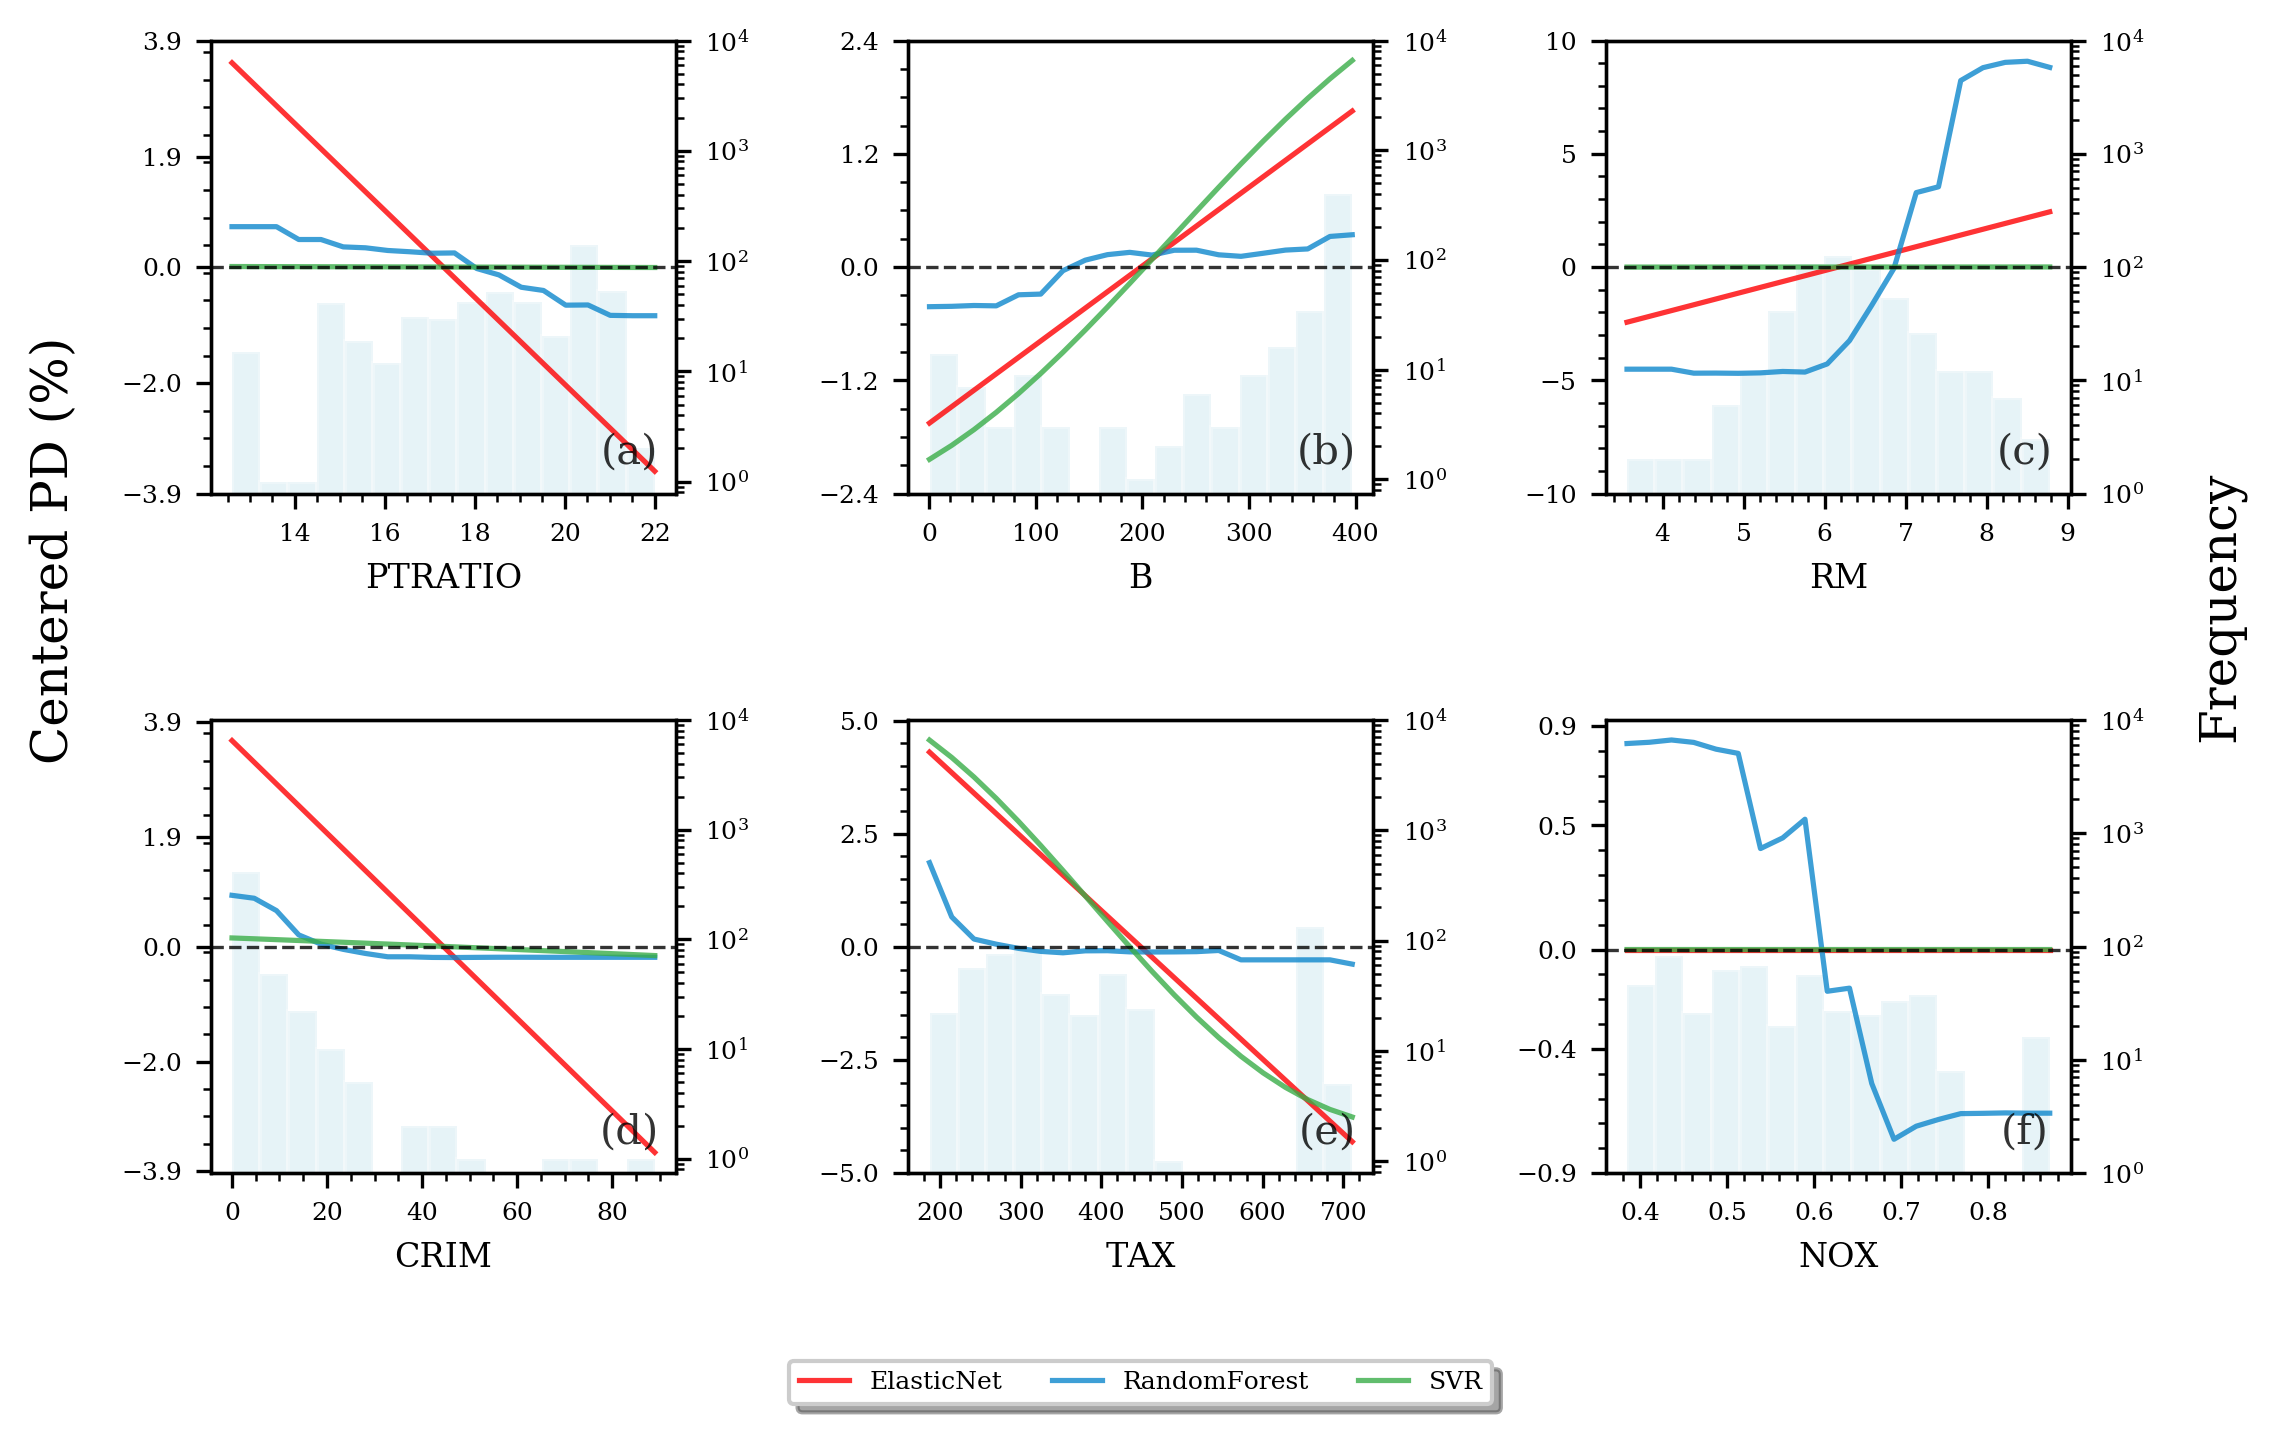

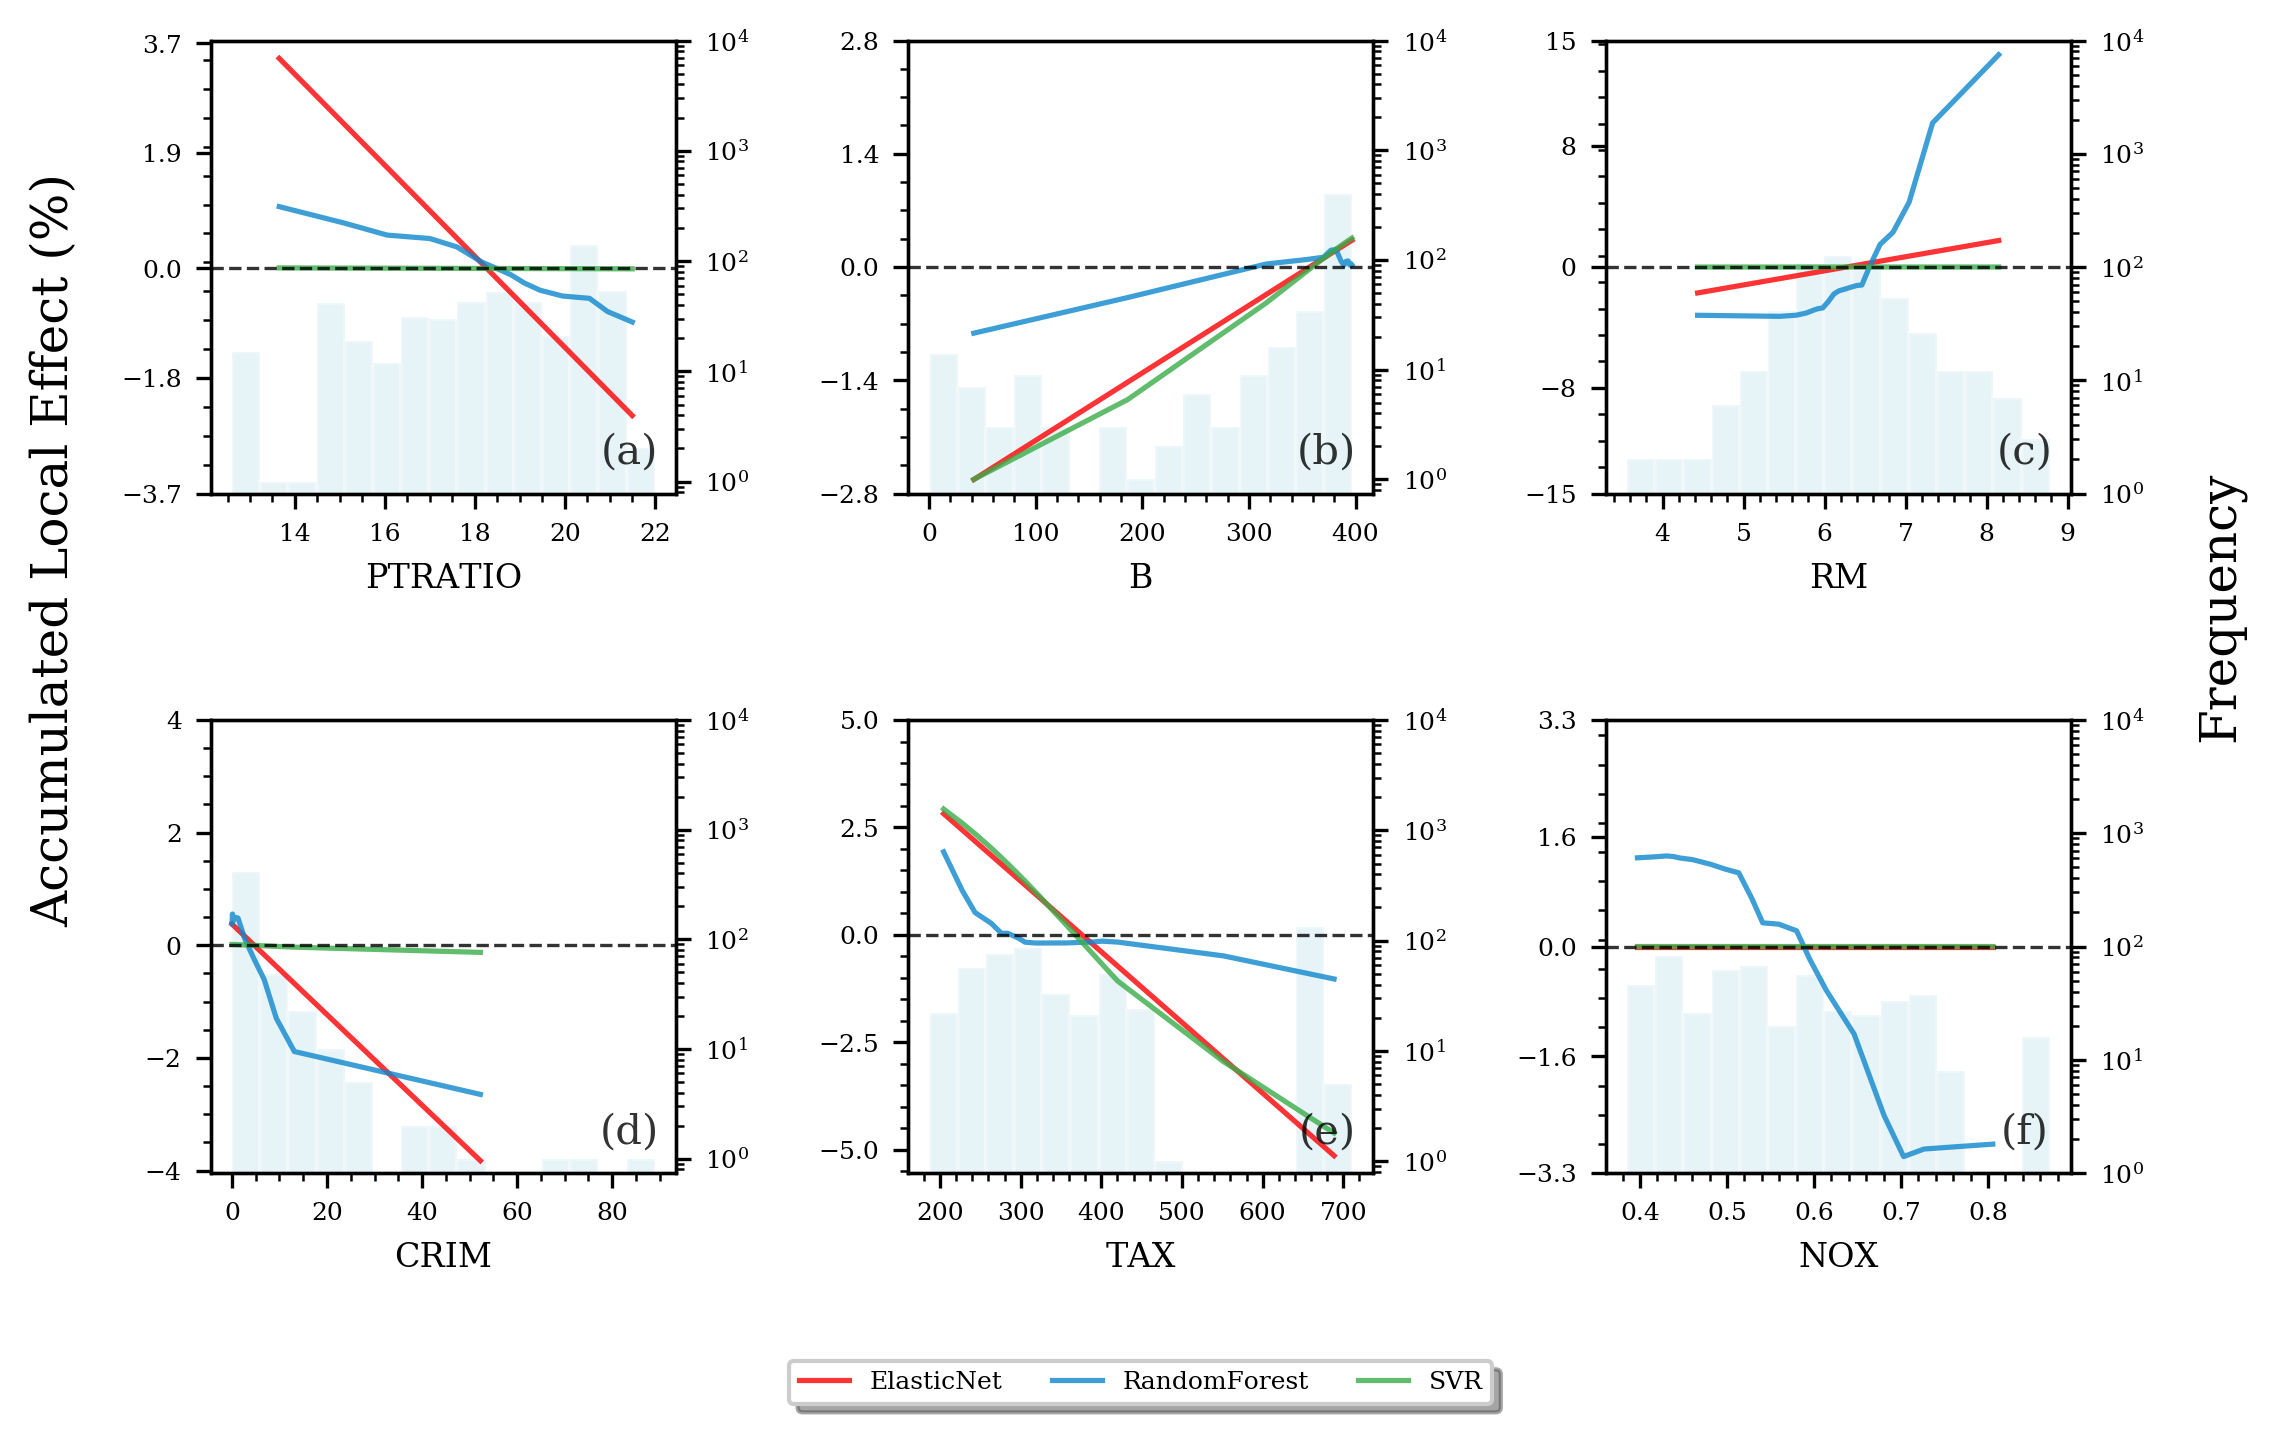

In [10]:
# run regression test
run_regression_test(interpreter)